# PL Intensity as a Function of STED Delay Time
Notebook that produces a graph depicting the change in the intensity of the measured PL from the spectrometer as the STED delay time is altered using the linear stage

# Things That Might Be Nice To Add
-Ability to plot PL intensity over time graphs (exponential decay)

    -Would like to do this for every stage position

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
from lmfit import Model
from lmfit import create_params, minimize
from lmfit.printfuncs import report_fit
from scipy.optimize import curve_fit
from scipy.special import erfc

The data is in the form of a tab separated file with the headers representing the stage position in um and the temperature respectively. The two columns then represent the wavelength and the number of counts respectively

In [2]:
def import_file(position, control=False):
    """Function that takes the position of the stage in mm and loads the relevant file from my documents. Here I have
    set the document path to be constant so if the location of the file is to change then the file path will also need
    to change to. The optional argument of control sets whether or not to load the control data of just the green
    pulsed laser or the STED data."""
    position_string = '=' + str(position*1000) + '.00' #Creates a string of the position in um to search in the data folder. = is needed at the front to make sure the file at the 0 position doesn't return every multiple of 10mm aswell. '.00' is needed to stop single digit values of position also returning the position 10x greater.
    if control:
        filename = glob.glob(r'C:\Users\seanj\OneDrive\Documents\University\Year 4\NSCM001 MSci Research Project 2\Time Tagger Data\23-11-16\S0074_B2_34_69_STED_Spectrometer_Control_Green_78.1MHz_5s_1mmsteps\*' + position_string + '*')
    else:
        filename = glob.glob(r'C:\Users\seanj\OneDrive\Documents\University\Year 4\NSCM001 MSci Research Project 2\Time Tagger Data\23-11-16\S0074_B2_34_69_STED_Spectrometer_Red_and_Green_78.1MHz_5s_1mmsteps\*' + position_string + '*')
    #data = pd.read_csv(filename[0], delimiter = '\t')
    data = np.loadtxt(filename[0])
    return data 

In [3]:
def separate_arrays(data):
    """Function that takes the data from the text file in the form of a 2xn array and returns 2 separate arrays of the
    wavelength and counts"""
    no_header = data[1:] #the first array of Data is the position in um and the temperature. Don't want this so remove this from the array
    #Separate the Wavelength and Counts into separate arrays
    Wavelength = []
    Counts = []
    for n in no_header:
        Wavelength.append(n[0])
        Counts.append(n[1])
    return Wavelength, Counts

In [4]:
def Wavelength_to_Index(Wavelength):
    """Function that takes a wavelength input and returns the relevant index of the wavelength array that realtes
    to that wavelength."""
    #These Values taken from one of the spectra
    Min_Wavelength = 541.136
    Max_Wavelength = 857.41
    Length_of_array = 2000
    Index = round(((Wavelength - Min_Wavelength)*Length_of_array)/(Max_Wavelength-Min_Wavelength))
    return Index

In [5]:
def Integral_Under_Spectrum(Wavelength, Counts, Plot_Graph=False, Min_Wavelength=560, Max_Wavelength=572):
    """Function that calculates the integral under the PL spectrum"""
    Total_Integral = np.trapz(Counts, Wavelength)
    Filtered_Integral = np.trapz(Counts[Wavelength_to_Index(Min_Wavelength):Wavelength_to_Index(Max_Wavelength)], Wavelength[Wavelength_to_Index(Min_Wavelength):Wavelength_to_Index(Max_Wavelength)])
    if Plot_Graph:
        plt.figure(figsize = (20, 12))
        #plt.plot(Wavelength, Counts)
        plt.plot(Wavelength[Wavelength_to_Index(Min_Wavelength):Wavelength_to_Index(Max_Wavelength)], Counts[Wavelength_to_Index(Min_Wavelength):Wavelength_to_Index(Max_Wavelength)])
        plt.xlabel('Wavelength (nm)', fontsize=24)
        plt.ylabel('Counts', fontsize=24)
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        plt.title('Stage Position = 5mm', fontsize=28)
    return Total_Integral, Filtered_Integral

(492984.0835000002, 243355.03650000002)

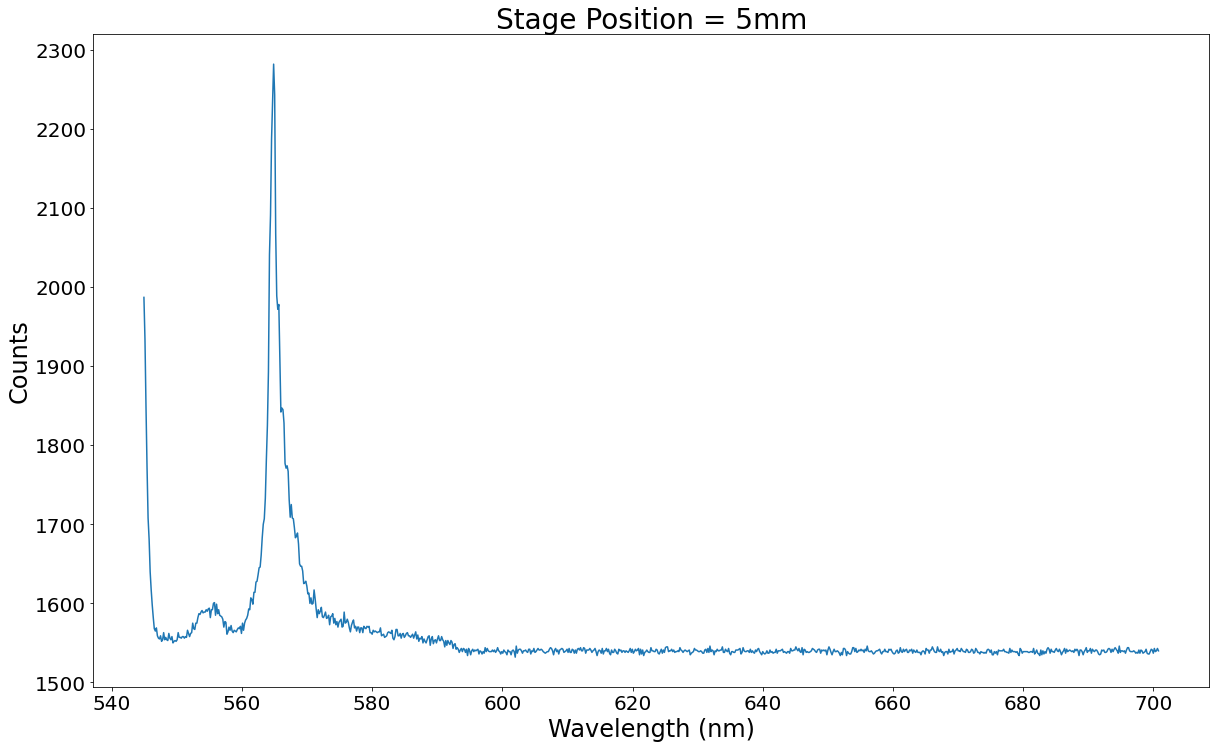

In [21]:
Integral_Under_Spectrum(separate_arrays(import_file(5, control=True))[0], separate_arrays(import_file(5, control=True))[1], Min_Wavelength=545, Max_Wavelength=700,Plot_Graph=True)
#Integral_Under_Spectrum(separate_arrays(import_file(5))[0], separate_arrays(import_file(5))[1], Min_Wavelength=545, Max_Wavelength=700,Plot_Graph=True)

In [7]:
def Time_Difference(Position, Zero_Delay_Position=34.7):
    """Function that calculates the time difference between the STED pulse and the excitation pulse. The Zero Stage
    Position is set to be 34.7mm from previous experimental data and is the position at which the STED pulse
    arrives. Position is the position of the stage in mm."""
    #The stage position of 0mm is the relates to the longest path of the green laser pulse and 100mm relates to the
    #shortest path of travel for the green pulse.
    Position_Difference = Position - Zero_Delay_Position #A positive position difference equates to the STED pulse arriving after the excitation pulse
    Time_Difference = (2*Position_Difference) / 2.9979e11 #Here the speed of light is in mm/s and Position_Difference is multiplied by 2 because the light travels to the linear stage mirror and back again
    return Time_Difference

In [8]:
#Normalising the intensity difference
def Normalise(Intensity):
    """Function that takes an input intensity and normalises it"""
    Max_Intensity = max(Intensity)
    Min_Intensity = min(Intensity)
    Normalised = []
    for i in Intensity:
        Normalised.append((i-Min_Intensity)/(Max_Intensity-Min_Intensity))
    return Normalised

In [9]:
Integral_Under_Spectra_Control = []
# Integral_Under_Spectra_Control2 = []
Integral_Under_Spectra_STED = []
Time_Delay_ps = [] #Here I am calculating the Time Delay in picoseconds to make the figure more readable and match the scale used of the same graph in the literature
for i in range(101):
    #Here I am using the Filtered Integral as this is the bit we are interested in
    Integral_Under_Spectra_Control.append(Integral_Under_Spectrum(separate_arrays(import_file(i, control=True))[0], separate_arrays(import_file(i, control=True))[1], Min_Wavelength=563, Max_Wavelength=567)[1])
#     Integral_Under_Spectra_Control2.append(Integral_Under_Spectrum(separate_arrays(import_file(i, control=True))[0], separate_arrays(import_file(i, control=True))[1], Min_Wavelength=566, Max_Wavelength=570)[1])
    Integral_Under_Spectra_STED.append(Integral_Under_Spectrum(separate_arrays(import_file(i))[0], separate_arrays(import_file(i))[1], Min_Wavelength=563, Max_Wavelength=567)[1])
    Time_Delay_ps.append(Time_Difference(i)*1e12)

In [10]:
#Calculating the difference between the STED and the Control in an attempt to remove any trend that is caused by the 
#movement of the stage rather than the STED pulse as such trends should appear in both the STED and Control data
STED_Control_Difference = []
# STED_Control_Difference2 = []
for i in range(len(Integral_Under_Spectra_STED)):
    STED_Control_Difference.append(Integral_Under_Spectra_STED[i] - Integral_Under_Spectra_Control[i])
#     STED_Control_Difference2.append(Integral_Under_Spectra_STED[i] - Integral_Under_Spectra_Control2[i])

In [11]:
Normalised_Difference = Normalise(STED_Control_Difference)
# Normalised_Difference2 = Normalise(STED_Control_Difference2)

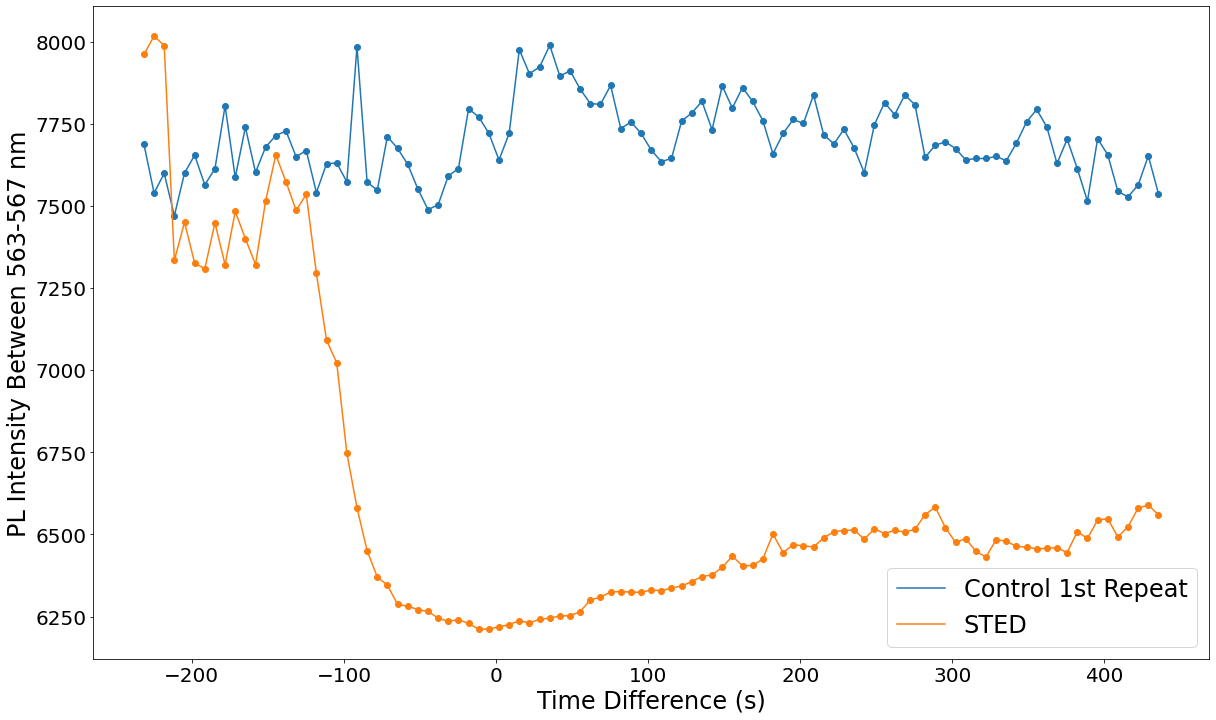

In [20]:
plt.figure(figsize = (20, 12))
plt.plot(Time_Delay_ps, Integral_Under_Spectra_Control, label='Control 1st Repeat')
plt.scatter(Time_Delay_ps, Integral_Under_Spectra_Control)
plt.plot(Time_Delay_ps, Integral_Under_Spectra_STED, label='STED')
plt.scatter(Time_Delay_ps, Integral_Under_Spectra_STED)
# plt.plot(Time_Delay_ps, Integral_Under_Spectra_Control2, label='Control 2nd Repeat')
# plt.scatter(Time_Delay_ps, Integral_Under_Spectra_Control2)
plt.xlabel('Time Difference (s)', fontsize = 24)
plt.ylabel('PL Intensity Between 563-567 nm', fontsize = 24)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(fontsize = 24)
#plt.savefig('STED_and_Control_Intensities.pdf')

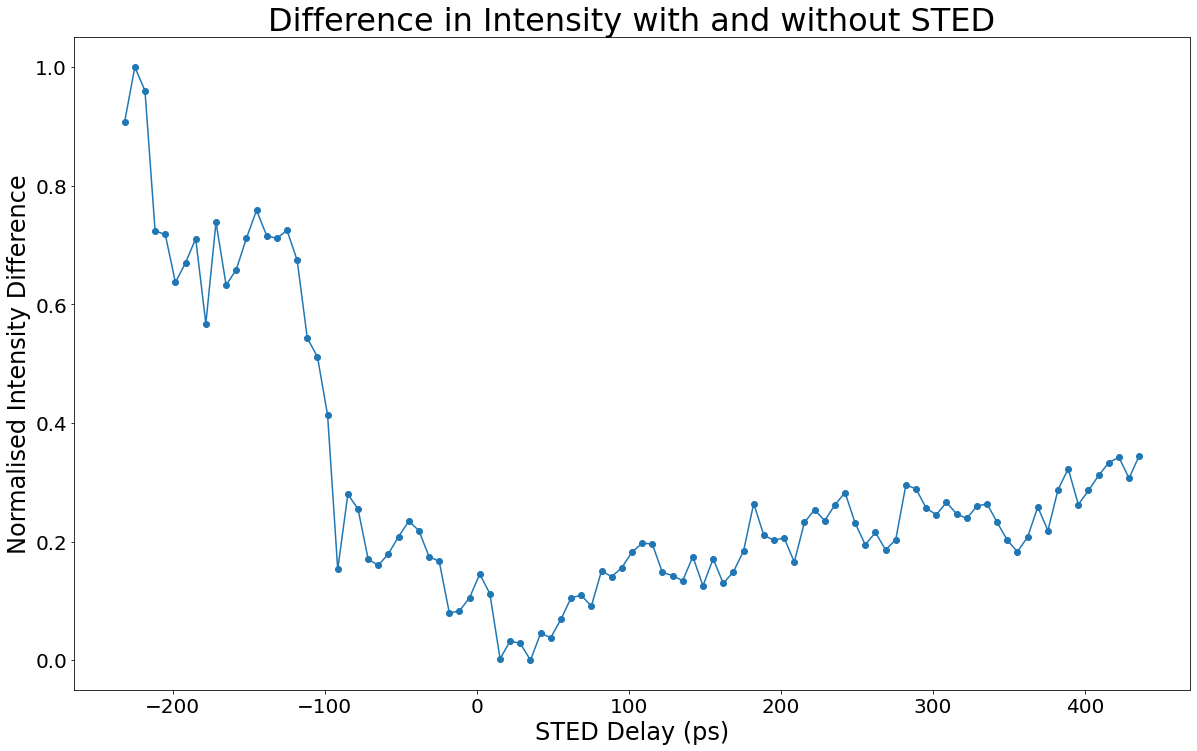

In [18]:
plt.figure(figsize = (20, 12))
plt.plot(Time_Delay_ps, Normalised_Difference, label='Repeat 1')
plt.scatter(Time_Delay_ps, Normalised_Difference)
# plt.plot(Time_Delay_ps, Normalised_Difference2, label='Repeat 2')
# plt.scatter(Time_Delay_ps, Normalised_Difference2)
# plt.plot(Time_Delay_ps, STED_Control_Difference, label='Repeat 1')
# plt.scatter(Time_Delay_ps, STED_Control_Difference)
plt.xlabel('STED Delay (ps)', fontsize = 24)
plt.ylabel('Normalised Intensity Difference', fontsize = 24)
plt.title('Difference in Intensity with and without STED', fontsize = 32)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
#plt.legend(fontsize=24)
#plt.savefig('STED_and_Control_Difference.pdf')

# Curve Fitting
Want to find a fit for the data

The 'Gaussian-like' start to the graph (the part before the minimum), is due to inherent delays in the recording of the PL by the Time Tagger, known as the $\textbf{Intrument Response Function}$. In an ideal scenario, when the STED Delay reaches 0 you would expect an instant drop-off straight to the minimum intensity. However the $\textbf{Intrument Response Function}$ causes this instant drop-off to spread out. The $\textbf{Instrument Response Function}$ can be modelled as a Gaussian with FWHM of 330 ps (Baber, 2023). The standard deviation of the Gaussian can be calculated as $\sigma = \frac{\text{FWHM}}{2\sqrt{2\text{ln}(2)}}$.

The function we will be fitting the data to is an exponentially modified Gaussian,

$$f(t) = 1 - h(t)$$

where,

$$h(t) = A \text{exp}\left[\frac{t_{0}-t}{\tau} + \frac{\sigma^{2}}{2\tau^{2}}\right]\text{erfc}\left[\frac{t_0-t+\frac{\sigma^2}{\tau}}{\sqrt{2}\sigma}\right]$$

In [110]:
def Exponentially_Modified_Gaussian(t, a, t_0, tau, FWHM = 3):
    """Defines the function that will be used to fit the data. The unit of time used is ps."""
    sigma = FWHM / (2*np.sqrt(2*np.log(2)))    
    exponential = np.exp((t_0-t)/tau + sigma**2/(2*tau**2))
    c_error_function = erfc((t_0-t+(sigma**2/tau))/(sigma*np.sqrt(2))) 
    h = a*exponential*c_error_function
    f = 1-h
    return f         

In [111]:
def Double_Exponentially_Modified_Gaussian(t, t_0, b, a1, tau1, a2, tau2, FWHM=3):
    """The sum of two exponentially modified Gaussian functions"""
    sigma = FWHM / (2*np.sqrt(2*np.log(2)))
    f = b*(Exponentially_Modified_Gaussian(t, t_0, a1, tau1, FWHM=FWHM) + Exponentially_Modified_Gaussian(t, t_0, a2, tau2, FWHM=FWHM))
    return f

In [108]:
def fit_using_scipy(fitting_function, x, y, Plot_Graph=True, Print_Values=True, p=[]):
    """Using the Scipy.optimize.curve_fit function to fit the data to the fitting function. p is an optional initial
    guess for the parameters. maxfev defines the number of iterations the optimisation goes through. It can be increased
    if the function is too complicated for a solution to be found with the default (1800), or if you want more 
    accuracy, however this will be more computationally intensive."""
    if len(p) == 0:
        parameters = curve_fit(fitting_function, x, y)[0]
    else:
        parameters = curve_fit(fitting_function, x, y, p0=p)[0]
        
    if Print_Values:
        print(parameters)
    
    if Plot_Graph:
        plt.figure(figsize = (20, 12))
        plt.scatter(x, y, s=12)
        plt.plot(x, fitting_function(x, parameters[0], parameters[1], parameters[2], parameters[3], parameters[4]))
        plt.xticks(fontsize = 20)
        plt.yticks(fontsize = 20)

In [129]:
def fit_using_lmfit(fitting_function, x, y, Print_Values=True, Plot_Graph=True, Double=False):
    """Using the lmfit library to fit the data to the fitting function. For now this requires the use of the
    exponentially modified Gaussian fitting function that I defined above, with the inital guesses used below. 
    Maybe in the future I could change this so that a user can input the guess values for the function and a 
    True/Flase for if to vary it. Then append all these values to the params, to give a list of all the parameters 
    required for any function.
    Set Double equal to True when modelling with the double modified gaussian function. However, currently there are
    errors with the Double Gaussian function with lmfit becuase it sometimes runs out of iterations before it finds 
    a solution."""
    function_model = Model(fitting_function)
    if Double:
        params = function_model.make_params(
                                    b=dict(value=1, vary=True, min=0),
                                    t_0=dict(value=0, vary=True),
                                    a1=dict(value=0.5, vary=True, max=1, min=0),
                                    tau1=dict(value=320, vary=True),
                                    a2=dict(value=0.5, vary=True, expr='1.0-a1'),
                                    tau2=dict(value=320, vary=True),
                                    FWHM=dict(value=3, vary=True, max=10, min=1))
    else:
        params = function_model.make_params(
                                    a=dict(value=0.5, vary=True, max=1, min=0),
                                    t_0=dict(value=0, vary=True, max=1, min=-1),
                                    tau=dict(value=320, vary=True),
                                    FWHM=dict(value=3, vary=True, max=100, min=1))#FWHM should be a few ps, so contrain it to be within that order of magnitude
    
    result = function_model.fit(Normalised_Difference, params, t=Time_Delay_ps)
    
    if Print_Values:
        params.pretty_print()
        print(function_model.param_names, function_model.independent_vars)
        report_fit(result)
    
    if Plot_Graph:
        plt.figure(figsize = (20, 12))
        plt.scatter(Time_Delay_ps, Normalised_Difference)
        plt.plot(Time_Delay_ps, result.best_fit)
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)

C:\Users\seanj\Anaconda3.1\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


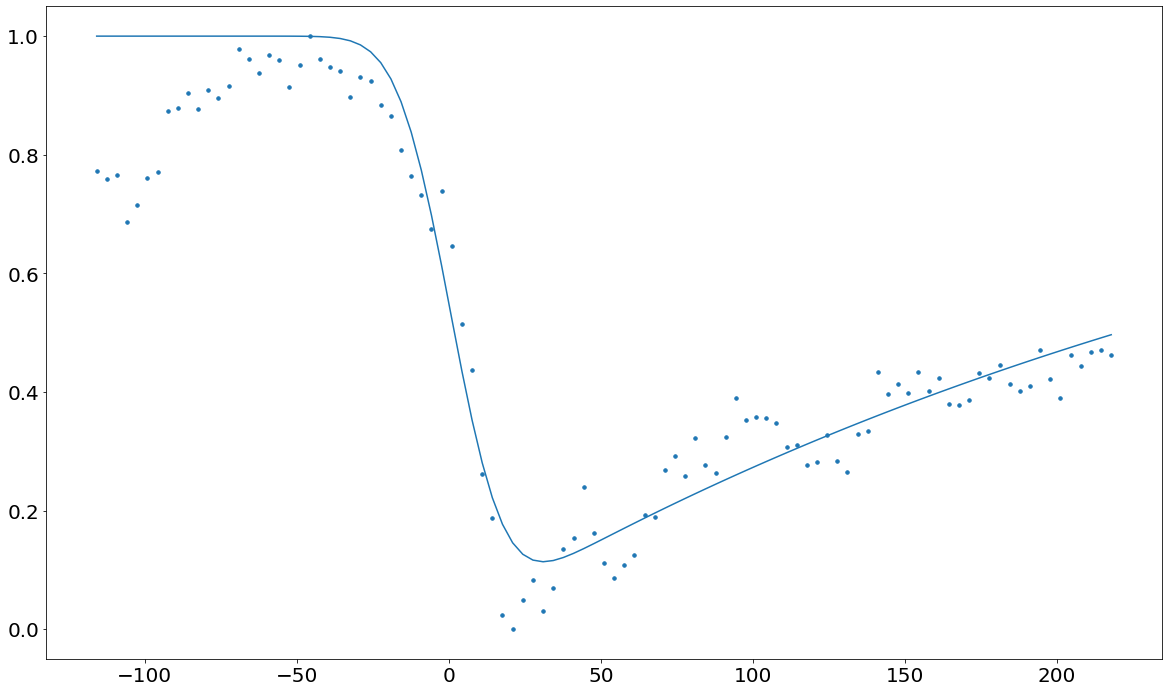

In [76]:
fit_using_scipy(Exponentially_Modified_Gaussian, Time_Delay_ps, Normalised_Difference, p=[0.5, 1, 320, ])

In [99]:
fit_using_scipy(Double_Exponentially_Modified_Gaussian, Time_Delay_ps, Normalised_Difference, p=[0, 1, 1, 320, 1, 320, 13.89, 330])

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 1800.

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
FWHM         3        1      100     None     True     None     None
a          0.5        0        1     None     True     None     None
t_0          0       -1        1     None     True     None     None
tau        320     -inf      inf     None     True     None     None
['a', 't_0', 'tau', 'FWHM'] ['t']
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 59
    # data points      = 101
    # variables        = 4
    chi-square         = 0.84092039
    reduced chi-square = 0.00866928
    Akaike info crit   = -475.626259
    Bayesian info crit = -465.165777
    R-squared          = 0.90164680
[[Variables]]
    a:     0.49447155 +/- 0.01821579 (3.68%) (init = 0.5)
    t_0:   0.99999995 +/- 0.12718640 (12.72%) (init = 0)
    tau:   320.968730 +/- 34.4844140 (10.74%) (init = 320)
    FWHM:  32.7608743 +/- 4.47119443 (13.65%) (init = 3)
[[Correlations]] (unreported correlations are < 0.100)
 

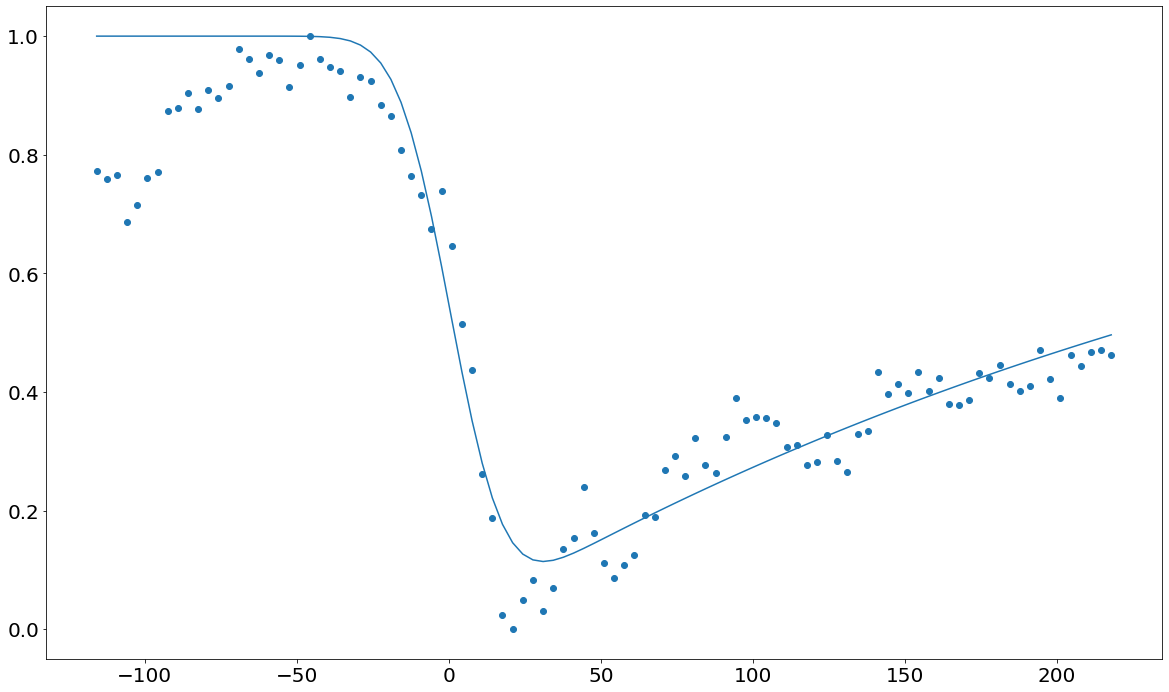

In [130]:
fit_using_lmfit(Exponentially_Modified_Gaussian, Time_Delay_ps, Normalised_Difference)

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
FWHM         3        1       10     None     True     None     None
a1         0.5        0        1     None     True     None     None
a2         0.5     -inf      inf     None    False   1.0-a1     None
b            1        0      inf     None     True     None     None
t_0          0     -inf      inf     None     True     None     None
tau1       320     -inf      inf     None     True     None     None
tau2       320     -inf      inf     None     True     None     None
['t_0', 'b', 'a1', 'tau1', 'a2', 'tau2', 'FWHM'] ['t']
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 14000
    # data points      = 101
    # variables        = 6
    chi-square         = 0.68010005
    reduced chi-square = 0.00715895
    Akaike info crit   = -493.064223
    Bayesian info crit = -477.373500
    R-squared          = 0.92045619
##  Warning: uncertainties could not be estimated:
    a1:    at bound

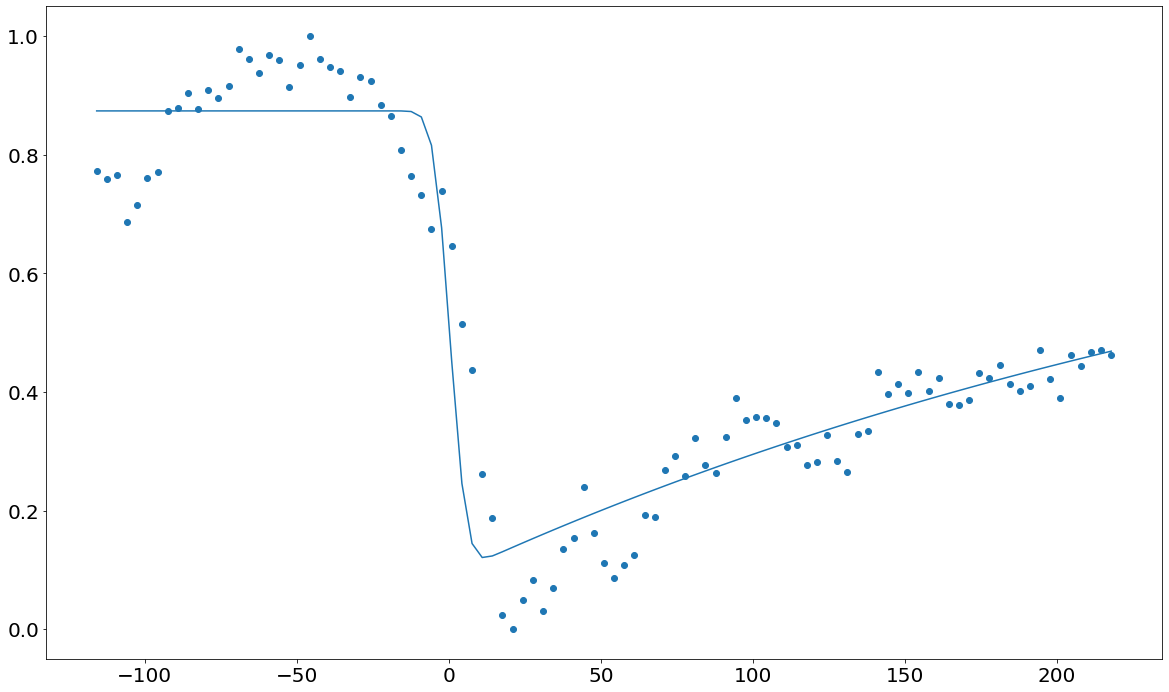

In [126]:
fit_using_lmfit(Double_Exponentially_Modified_Gaussian, Time_Delay_ps, Normalised_Difference, Double=True)